In [1]:
#preprecess imports

import pandas as pd
import spacy
import numpy as np
import en_core_web_sm
# nlp = spacy.load('en_core_web_sm')
nlp = en_core_web_sm.load()
from tqdm.notebook import tqdm 

# Essentials
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd

# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this 

# NLP stuff
import contractions
import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#nltk.download('wordnet')

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn 


In [2]:
df = pd.read_csv('practice.csv')

In [3]:
df = df.dropna(axis='rows')

In [4]:
df

,Unnamed: 0,pub_type,position_section,position_subsection,hl1,hl2,author,lede,body,language,word_count,copyright,content-id,volume,issue_number,edition,pub_name,pub_date,licensor_indexing_terms,indexing_terms
1,1,"Newspaper, Newspapers",SPORTS,Football-Patriots,Wilfork goes out a legend,Lineman leaves Pats for Texans,JEFF HOWE,Vince Wilfork will be immortalized as a Patrio...,'Few players reached or will ever reach the sp...,['ENGLISH'],576,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25185125,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"WILFORK, PATRIOTS, DEFENSIVE, COACH, LINEMAN, ...","{'legal': [{'className': 'Education Law', 'cla..."
2,2,"Newspaper, Newspapers",OPINION,Commentary,Hillary's modus operandi not pretty,'Nasty' GOP latest excuse for private email use,JENNIFER C. BRACERAS,Just when you thought we were done with emailg...,Didn't Clinton tell us that she set up the pri...,['ENGLISH'],642,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25223487,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"CLINTON, PRIVATE, EMAILS, CARVILLE, SERVER, AC...","{'subject': [{'score': '90', 'classCode': 'N81..."
6,6,"Newspaper, Newspapers",BUSINESS,Retail,RETAILERS FEAR TRASHED STREETS,Mess left beneath snow piles could slow return...,MARIE SZANISZLO,With dirty snowbanks still lining many streets...,'After this very tough winter for main streets...,['ENGLISH'],412,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25226117,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"APRIL, BOSTON, CONSUMERS, MAYOR, SNOW, SPRING,...","{'legal': [{'className': 'Governments', 'class..."
7,7,"Newspaper, Newspapers",FEATURES,Television-Television Reviews,Night of the laughing dead,"CW's 'iZombie' mixes horror, mystery, comedy",MARK A. PERIGARD,It's the 'Walking Dead' 'Quincy'/'Psych' mash...,"One night, the super-overachiever decides to t...",['ENGLISH'],502,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25223152,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"IZOMBIE, LIV, DEAD, BRAINS, HORROR, KOHLI, MCI...","{'subject': [{'score': '89', 'classCode': 'Z3V..."
8,8,"Newspaper, Newspapers",SPORTS,Baseball-Red Sox,Sox see what's missing,Harvey shows off top-of-rotation arm,JASON MASTRODONATO,"FORT MYERS - It's not just the results, the co...","The Red Sox don't have a Matt Harvey, and they...",['ENGLISH'],564,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25185113,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"HARVEY, SOX, RED, ACE, INNING, MATT, PITCHERS,...","{'subject': [{'score': '90', 'classCode': 'STX..."
14,14,"Newspaper, Newspapers",NEWS,Local,Cops give riveting firefight details,Shed light on a.m. battle with Tsarnaevs,LAUREL J. SWEET,The showdown with the bomb-tossing Tsarnaev br...,Watertown police Sgts. Jeffrey Pugliese and Jo...,['ENGLISH'],467,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25225885,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"TAMERLAN, PUGLIESE, DZHOKHAR, POLICE, REYNOLDS...","{'subject': [{'score': '90', 'classCode': 'ST0..."
17,17,"Newspaper, Newspapers",BUSINESS,Economy,Make 'Madness' work at work,Have fun and staff will go through hoops,JUDITH BOWMAN,The phenomenon known as 'March Madness' has of...,Employees across the nation are sure to take t...,['ENGLISH'],384,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25228025,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"JUDITH, BOWMAN, MADNESS, RULES, MARCH, OPPORTU...","{'subject': [{'score': '90', 'classCode': 'ST0..."
21,21,"Newspaper, Newspapers",SPORTS,Basketball-Celtics,Right where C's belong,Win streak hits five as foes take notice,MARK MURPHY,The Celtics' reputation continued to shine las...,'I think they've improved a lot defensively si...,['ENGLISH'],572,Copyright 2015 Boston Herald Inc. All Rights R...,BHERLD-25231940,Vol. 33,No. 76,All Editions,The Boston Herald,17-03-2015,"CELTICS, ZELLER, SEASON, BRADLEY, WIN, GAME, P

In [5]:
def combine_led_body(df):
    body = df['body'].values
    lede = df['lede'].values
    arr = np.vstack((lede,body)).T
    for step, x in enumerate(arr): 
        arr[step] = ' '.join(x)

    arr = arr.flatten()
    return arr 

In [6]:
corpus = combine_led_body(df)

In [7]:
corpus #each body+lede combination is represented twice in corpus

array(["Vince Wilfork will be immortalized as a Patriot, but like so many, he won't be a Patriots lifer. The seven-time captain and five-time Pro Bowl defensive lineman signed with the Texans yesterday after a positive two-day visit with the Houston brass. Wilfork landed a two-year, $9 million contract, which included $5 million in guaranteed money, according to a source. And so ends Wilfork's 11-year run with the Patriots. The 2004 first-round pick opened his reign by surging to the top of the defensive tackle depth chart and becoming a fierce contributor for a Super Bowl champion. His tenure concluded with another victory on the world's greatest stage, and he was vindicated after returning from a torn Achilles while continuing as the defense's most prominent leadership presence. 'Few players reached or will ever reach the special level of Vince Wilfork,' Pats coach Bill Belichick said. 'He is a great champion and one of the classiest people I have ever been around, just a kind, genui

In [45]:
def custom_preprocess(corpus_iterable): 
    return [[z.lemma_.lower() for z in y if not (z.is_stop or z.text == '\n')] for y in 
tqdm(nlp.pipe(corpus_iterable), total = len(corpus_iterable)) ]

In [46]:
pre_processed_corpus = custom_preprocess(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.46it/s]


## TDS LDA Preprocessing and LDA outcomes

In [9]:
def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [10]:
print(preprocess(df['body']))
preprocessed_df = preprocess(df['body'])

1     player reached ever reach special level vince ...
2     not clinton tell set private server avoid carr...
6     tough winter main street vital consumer encour...
7     one night superoverachiever decides take night...
8     red sox not matt harvey received good reminder...
14    watertown police sgts jeffrey pugliese john ma...
17    employee across nation sure take time workday ...
21    think improved lot defensively since last time...
23    comforting not need stinking lottery pick crow...
25    yeah saw kind shaking arm little usual asked w...
28    good theory far plan one wonder sound like som...
35    opportunity sort poke fun let face know long w...
36    weeklong visit fulfill duty special instructor...
38    cowan tapped patrick february replace john ker...
43    completed season sweep philadelphia double dig...
Name: body, dtype: object


In [11]:
print(preprocessed_df.values[0])

player reached ever reach special level vince wilfork pat coach bill belichick said great champion one classiest people ever around kind genuine giving person team football winning bringing joy others may never anyone position much strength toughness intelligence instinctiveness athleticism best defensive lineman ever coached alltime great patriot whose place team missed whose remarkable career patriot remembered forever wilfork expected take time free agent circuit obvious connection texan coach bill obrien defensive coordinator romeo crennel linebacker coach mike vrabel former patriot employee play alongside defensive player year watt last year overall draft pick jadeveon clowney wilfork made quick decision first tour spurning supposed interest afc contender colt raven patriot declined wilforks option march season saved million cap wilfork never closed door return initial statement patriot not acknowledged transaction last night popular belief two side could still indeed reunite mend

In [12]:
print(df['body'].values[0])

'Few players reached or will ever reach the special level of Vince Wilfork,' Pats coach Bill Belichick said. 'He is a great champion and one of the classiest people I have ever been around, just a kind, genuine and giving person who was all about our team, football, winning and bringing joy to others. There may have never been anyone at his position with as much strength, toughness, intelligence, instinctiveness and athleticism. He is the best defensive lineman I ever coached, an all-time great Patriot whose place on our team will be missed but whose remarkable career as a Patriot will be remembered forever.' Wilfork was expected to take his time on the free agent circuit, but there was an obvious connection to Texans coach Bill O'Brien, defensive coordinator Romeo Crennel and linebackers coach Mike Vrabel, all former Patriots employees. He will now play alongside Defensive Player of the Year J.J. Watt and last year's No. 1 overall draft pick, Jadeveon Clowney. So, Wilfork made the qui

In [19]:
id2word.filter_extremes(no_below=15, no_above=0.4, keep_n=80000)

NameError: name 'id2word' is not defined

In [20]:
id2word = corpora.Dictionary(corpus.split())
id2word

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [17]:
corpus2 = [id2word.doc2bow(text) for text in id2word]

NameError: name 'id2word' is not defined

In [14]:
id2word

NameError: name 'id2word' is not defined

In [15]:
corpus2

NameError: name 'corpus2' is not defined

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#currently unsure how to work with doc2bow, pursuing other options

NameError: name 'id2word' is not defined

## Trying simpler method

In [29]:
# Use CountVectorizor to find three letter tokens, remove stop_words, 
# remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
from sklearn.feature_extraction.text import CountVectorizer

documents = pd.read_csv('practice.csv', error_bad_lines=False)
documents = documents.dropna(axis='rows')
documents.head()


vect = CountVectorizer(stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform
X = vect.fit_transform(documents.body)
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`
ldamodel = gensim.models.LdaMulticore(corpus=corpus, id2word=id_map, passes=4,
                                               random_state=50, num_topics=4, workers=2, per_word_topics = True)

/var/folders/gd/pxcx2w0x59j2bsjbzhy62nvw0000gn/T/ipykernel_9466/3987629053.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  documents = pd.read_csv('practice.csv', error_bad_lines=False)


In [30]:
for idx, topic in ldamodel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.013*"said" + 0.010*"sox" + 0.008*"team" + 0.006*"martinez" + 0.006*"red" + 0.006*"like" + 0.006*"just" + 0.006*"year" + 0.005*"wilfork" + 0.005*"spring"


Topic: 1 
Words: 0.009*"said" + 0.007*"board" + 0.006*"mcca" + 0.006*"cowan" + 0.006*"really" + 0.006*"don" + 0.005*"need" + 0.005*"just" + 0.005*"play" + 0.005*"game"


Topic: 2 
Words: 0.010*"clinton" + 0.006*"private" + 0.005*"emails" + 0.005*"said" + 0.004*"just" + 0.004*"didn" + 0.004*"server" + 0.004*"carville" + 0.004*"like" + 0.004*"night"


Topic: 3 
Words: 0.015*"said" + 0.009*"celtics" + 0.007*"harvey" + 0.005*"sox" + 0.005*"tamerlan" + 0.005*"points" + 0.004*"point" + 0.004*"left" + 0.004*"lead" + 0.004*"high"




In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [25]:
' '.join(df.body.tolist() ).lower() 

"'few players reached or will ever reach the special level of vince wilfork,' pats coach bill belichick said. 'he is a great champion and one of the classiest people i have ever been around, just a kind, genuine and giving person who was all about our team, football, winning and bringing joy to others. there may have never been anyone at his position with as much strength, toughness, intelligence, instinctiveness and athleticism. he is the best defensive lineman i ever coached, an all-time great patriot whose place on our team will be missed but whose remarkable career as a patriot will be remembered forever.' wilfork was expected to take his time on the free agent circuit, but there was an obvious connection to texans coach bill o'brien, defensive coordinator romeo crennel and linebackers coach mike vrabel, all former patriots employees. he will now play alongside defensive player of the year j.j. watt and last year's no. 1 overall draft pick, jadeveon clowney. so, wilfork made the qu

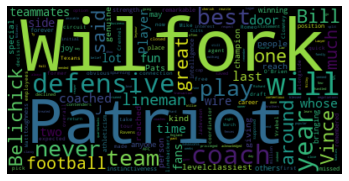

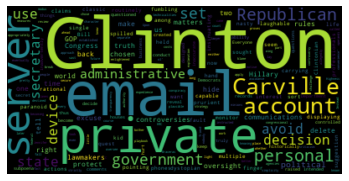

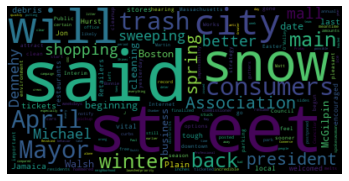

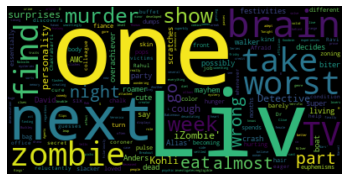

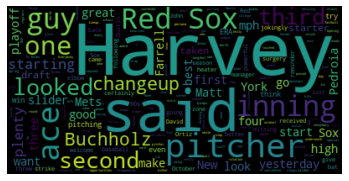

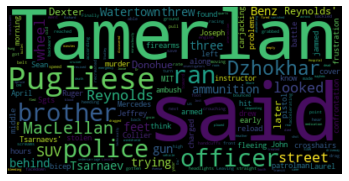

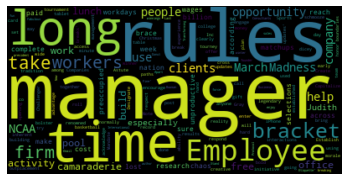

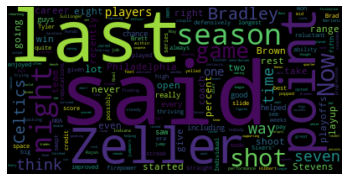

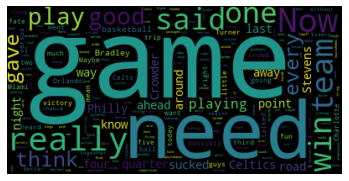

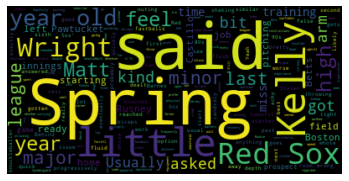

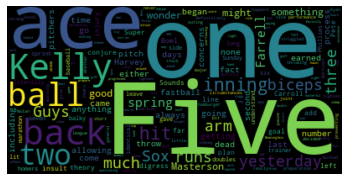

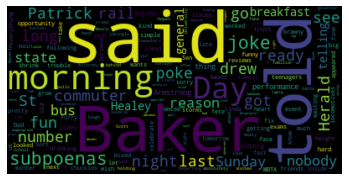

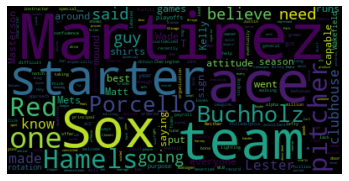

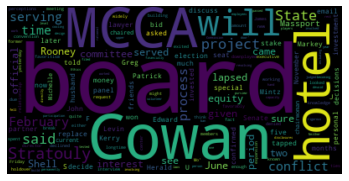

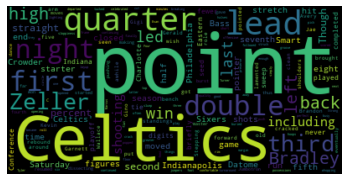

In [140]:
#filter the df to one candidate, and create a list of responses from them
import warnings
warnings.filterwarnings('ignore')

for i in df.body.values:
    text = i

    # join the list and lowercase all the words
    #text = ' '.join([text]).lower()

    #create the wordcloud object
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          collocations=True).generate(text)

    #plot the wordcloud object
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()

In [26]:

def topic_distribution(string_input):
    string_input = [string_input]
    # Fit and transform
    X = vect.transform(string_input)
    # Convert sparse matrix to gensim corpus.
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
    output = list(ldamodel[corpus])[0]
    return output
 
topic_distribution(documents.body[1])

([(2, 0.9960761)],
 [(11, [2]),
  (13, [2]),
  (15, [2]),
  (16, [2]),
  (17, [2]),
  (35, [2]),
  (45, [2]),
  (51, [2]),
  (60, [2]),
  (65, [2]),
  (95, [2]),
  (139, [2]),
  (140, [2]),
  (147, [2]),
  (148, [2]),
  (160, [2]),
  (197, [2]),
  (199, [2]),
  (203, [2]),
  (220, [2]),
  (229, [2]),
  (235, [2]),
  (265, [2]),
  (273, [2]),
  (281, [2]),
  (289, [2]),
  (290, [2]),
  (306, [2]),
  (307, [2]),
  (308, [2]),
  (311, [2]),
  (312, [2]),
  (313, [2]),
  (319, [2]),
  (357, [2]),
  (365, [2]),
  (366, [2]),
  (377, [2]),
  (387, [2]),
  (402, [2]),
  (427, [2]),
  (439, [2]),
  (441, [2]),
  (442, [2]),
  (503, [2]),
  (510, [2]),
  (545, [2]),
  (548, [2]),
  (552, [2]),
  (573, [2]),
  (583, [2]),
  (600, [2]),
  (602, [2]),
  (620, [2]),
  (659, [2]),
  (661, [2]),
  (664, [2]),
  (672, [2]),
  (683, [2]),
  (686, [2]),
  (693, [2]),
  (702, [2]),
  (705, [2]),
  (719, [2]),
  (734, [2]),
  (738, [2]),
  (746, [2]),
  (749, [2]),
  (821, [2]),
  (837, [2]),
  (848, [2])